<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/Crypto_Binance_Historical_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetch historical data

Python script to fetch historical data from binance using ccxt



In [1]:
# Install openpyxl and CCXT
!pip install openpyxl ccxt pyarrow

In [2]:
import os
from pathlib import Path

import sys
import csv

# -----------------------------------------------------------------------------

root = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(''))))
sys.path.append(root + '/python')

import ccxt


# -----------------------------------------------------------------------------

def retry_fetch_ohlcv(exchange, max_retries, symbol, timeframe, since, limit):
    num_retries = 0
    try:
        num_retries += 1
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        # print('Fetched', len(ohlcv), symbol, 'candles from', exchange.iso8601 (ohlcv[0][0]), 'to', exchange.iso8601 (ohlcv[-1][0]))
        return ohlcv
    except Exception:
        if num_retries > max_retries:
            raise  # Exception('Failed to fetch', timeframe, symbol, 'OHLCV in', max_retries, 'attempts')


def scrape_ohlcv(exchange, max_retries, symbol, timeframe, since, limit):
    earliest_timestamp = exchange.milliseconds()
    timeframe_duration_in_seconds = exchange.parse_timeframe(timeframe)
    timeframe_duration_in_ms = timeframe_duration_in_seconds * 1000
    timedelta = limit * timeframe_duration_in_ms
    all_ohlcv = []
    while True:
        fetch_since = earliest_timestamp - timedelta
        ohlcv = retry_fetch_ohlcv(exchange, max_retries, symbol, timeframe, fetch_since, limit)
        # if we have reached the beginning of history
        if ohlcv is None:
            print(f"{symbol} ohlcv is none")
            break

        if len(ohlcv) > 0:
            if ohlcv[0][0] >= earliest_timestamp:
                break
            earliest_timestamp = ohlcv[0][0]
            all_ohlcv = ohlcv + all_ohlcv
            print(len(all_ohlcv), symbol, 'candles in total from', exchange.iso8601(all_ohlcv[0][0]), 'to', exchange.iso8601(all_ohlcv[-1][0]))
            # if we have reached the checkpoint
            if fetch_since < since:
                break
        else:
            break
    return all_ohlcv


def write_to_csv(filename, exchange, data):
    p = Path("./data/raw/", str(exchange))
    p.mkdir(parents=True, exist_ok=True)
    full_path = p / str(filename)
    with Path(full_path).open('w+', newline='') as output_file:
        csv_writer = csv.writer(output_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerows(data)


def scrape_candles_to_csv(filename, exchange_id, max_retries, symbol, timeframe, since, limit):
    # instantiate the exchange by id
    exchange = getattr(ccxt, exchange_id)({
        'enableRateLimit': True,  # required by the Manual
    })
    # convert since from string to milliseconds integer if needed
    if isinstance(since, str):
        since = exchange.parse8601(since)
    # preload all markets from the exchange
    exchange.load_markets()
    # fetch all candles
    ohlcv = scrape_ohlcv(exchange, max_retries, symbol, timeframe, since, limit)
    # save them to csv file
    write_to_csv(filename, exchange, ohlcv)
    print('Saved', len(ohlcv), 'candles from', exchange.iso8601(ohlcv[0][0]), 'to', exchange.iso8601(ohlcv[-1][0]), 'to', filename)


def scrape_all_candles_to_csv(exchange_id, max_retries, timeframe, since, limit):
    # instantiate the exchange by id
    exchange = getattr(ccxt, exchange_id)({
        'enableRateLimit': True,  # required by the Manual
    })
    # convert since from string to milliseconds integer if needed
    if isinstance(since, str):
        since = exchange.parse8601(since)
    # preload all markets from the exchange
    exchange.load_markets()
    for symbol in exchange.symbols:
        splits = symbol.split("/")
        if len(splits) == 2:
            symbol_dict = {"symbol": symbol,
                           "base": splits[0],
                           "quote": splits[1]}
            # fetch all candles
            if symbol_dict['quote'] in ["USD", "USDT", "BUSD", "USDC"]:
                ohlcv = scrape_ohlcv(exchange, max_retries, symbol, timeframe, since, limit)
                # save them to csv file
                filename = f'{exchange_id}_{splits[0]}_{splits[1]}_{timeframe}.csv'
                write_to_csv(filename, exchange, ohlcv)
                if len(ohlcv):
                    print('Saved', len(ohlcv), 'candles from', exchange.iso8601(ohlcv[0][0]), 'to', exchange.iso8601(ohlcv[-1][0]), 'to', filename)
                else:
                    print(f"len ohlcv {symbol} is 0")
            else:
                print(f"{symbol}: {symbol_dict['quote']} not in [USD, USDT, BUSD, USDC]")
        else:
            print(f"{symbol} not correctly splittable")

#scrape_all_candles_to_csv('binance', 3, '1d', '2001-09-0100:00:00Z', 1000)
#scrape_all_candles_to_csv('bitfinex', 3, '1d', '2001-09-0100:00:00Z', 1000)

# scrape_candles_to_csv('btc_usdt_1m.csv', 'binance', 3, 'BTC/USDT', '1m', '2019-01-0100:00:00Z', 1000)
# scrape_candles_to_csv('./data/raw/binance/eth_btc_1m.csv', 'binance', 3, 'ETH/BTC', '1m', '2018-01-01T00:00:00Z', 1000)
# scrape_candles_to_csv('./data/raw/binance/ltc_btc_1m.csv', 'binance', 3, 'LTC/BTC', '1m', '2018-01-01T00:00:00Z', 1000)
# scrape_candles_to_csv('./data/raw/binance/xlm_btc_1m.csv', 'binance', 3, 'XLM/BTC', '1m', '2018-01-01T00:00:00Z', 1000)

In [3]:
import numpy as np
from glob import glob
from tqdm import tqdm
import pandas as pd


def resample_df_ohlcv(df, timeframe, label='right'):
    #df['vwap'] = df['vwap'] * df['volume']

    # Created a dictionary to tell Pandas how to re-sample, if this isn't in place it will re-sample each column separately
    ohlcv_dict = {'open':'first',
                  'high':'max',
                  'low':'min',
                  'close': 'last',
                  'volume': 'sum',
                  'vwap': 'sum'}
    # Resample to 15Min (this format is needed) as per ohlc_dict, then remove any line with a NaN
    df = df.resample(timeframe, label=label, closed=label).agg(ohlcv_dict)

    #df['vwap'] = df['vwap'] / df['volume']

    #df = nans_to_prev_close_method1(df)
    # Resample mixes the columns so lets re-arrange them
    cols = ['open', 'high', 'low', 'close', 'vwap', 'volume']
    df = df[cols]
    return df


def nans_to_prev_close_method1(df):
    df['volume'].fillna(0.0, inplace=True)  # volume should always be 0 (if there were no trades in this interval)
    df['close'].fillna(method='ffill', inplace=True)  # ie pull the last close into this close

    # now copy the close that was pulled down from the last timestep into this row, across into o/h/l
    df['open'].fillna(df['close'], inplace=True)
    df['low'].fillna(df['close'], inplace=True)
    df['high'].fillna(df['close'], inplace=True)
    df['vwap'].fillna(df['close'], inplace=True)
    return df

data = {'open':  [np.nan, '1.0', '2.0', np.nan, np.nan, '5.0', np.nan],
        'low':  [np.nan, '1.1', '2.1', np.nan, np.nan, '5.1', np.nan],
        'high':  [np.nan, '1.2', np.nan, np.nan, np.nan, '5.2', np.nan],
        'close':  [np.nan, '1.3', '2.3', np.nan, np.nan, '5.3', np.nan],
        'volume':  [np.nan, '1.4', '2.4', np.nan, np.nan, '5.4', np.nan],
        'vwap':  [np.nan, '1.5', '2.5', np.nan, np.nan, '5.5', np.nan],
        }#%%

nans_to_prev_close_method1(pd.DataFrame(data))


,open,low,high,close,volume,vwap
0,NaN,NaN,NaN,NaN,0.0,NaN
1,1.0,1.1,1.2,1.3,1.4,1.5
2,2.0,2.1,2.3,2.3,2.4,2.5
3,2.3,2.3,2.3,2.3,0.0,2.3
4,2.3,2.3,2.3,2.3,0.0,2.3
5,5.0,5.1,5.2,5.3,5.4,5.5
6,5.3,5.3,5.3,5.3,0.0,5.3


In [4]:
timeframe='1d'
minutes = 24*60
exchange_id = '*'

def prices_from_csv(minutes, exchange_id = '*', timeframe = '1d'):
    # read folder
    folder_path = f"./data/raw/{exchange_id}/*_{timeframe}*"
    print(folder_path)
    file_list = glob(folder_path + f"*.csv")
    print(file_list)
    pairs = []
    for file in tqdm(file_list):
        df = pd.read_csv(file, header=None, names=['date', 'open', 'high',
                                                   'low', 'close', 'volume']) # read the csv
        split_fname = file.replace(f"./data/raw/{exchange_id}/", "").replace(".csv", "").split("_")
        exchange_id = split_fname[0].split("/")[-1]

        quote = split_fname[2]
        base = split_fname[1]
        timeframe = split_fname[3]

        exchange = getattr(ccxt, exchange_id)({
                            'enableRateLimit': True,  # required by the Manual
                            })
        df['date'] = df.date.values.astype(dtype='datetime64[ms]')
        df.set_index(['date'], inplace=True)

        # approximate volume weighted average price by
        df['vwap'] = df['open']/4 + df['close']/4 + df['low']/4 + df['high']/4

        # shift to have the interval closed to the right
        df = df.shift(1)

        # resample to desired frequency and fill forward missing prices
        # if base_timeframe != target_timeframe:
        df = resample_df_ohlcv(df, f'{minutes}min', label='right')
        df = nans_to_prev_close_method1(df)

        df['dollar_vol'] = df.volume.mul(df.close)
        df.sort_index(inplace=True)
        df['dollar_vol_90d_rolling'] = df['dollar_vol'].rolling(window=int(90*24*60/minutes), min_periods=1).sum()

        df['exchange'] = exchange_id
        df['symbol'] = f"{base}_{quote}"
        df['base'] = base
        df['quote'] = quote
        df['timeframe'] = timeframe

        df.set_index(['base', 'exchange', 'symbol', 'quote', 'timeframe'], inplace=True, append=True)

        pairs.append(df)
    prices_ccxt = pd.concat(pairs)
    prices_ccxt.sort_index(inplace=True)
    return prices_ccxt

prices_ccxt = prices_from_csv(minutes, exchange_id=exchange_id, timeframe=timeframe)

./data/raw/*/*_1d*
['./data/raw/Binance/binance_BTCST_BUSD_1d.csv', './data/raw/Binance/binance_BTC_USDT_1d.csv', './data/raw/Binance/binance_LPT_USDT_1d.csv', './data/raw/Binance/binance_BNB_USDC_1d.csv', './data/raw/Binance/binance_AAVEDOWN_USDT_1d.csv', './data/raw/Binance/binance_GXS_USDT_1d.csv', './data/raw/Binance/binance_BTT_BUSD_1d.csv', './data/raw/Binance/binance_NMR_USDT_1d.csv', './data/raw/Binance/binance_BEL_USDT_1d.csv', './data/raw/Binance/binance_EOSBULL_USDT_1d.csv', './data/raw/Binance/binance_ETHBULL_BUSD_1d.csv', './data/raw/Binance/binance_TRB_USDT_1d.csv', './data/raw/Binance/binance_OGN_BUSD_1d.csv', './data/raw/Binance/binance_HARD_USDT_1d.csv', './data/raw/Binance/binance_TRX_USDC_1d.csv', './data/raw/Binance/binance_OM_USDT_1d.csv', './data/raw/Binance/binance_RARE_USDT_1d.csv', './data/raw/Binance/binance_RAD_BUSD_1d.csv', './data/raw/Binance/binance_LPT_BUSD_1d.csv', './data/raw/Binance/binance_CREAM_BUSD_1d.csv', './data/raw/Binance/binance_COS_USDT_1d.cs

100%|██████████| 887/887 [00:09<00:00, 89.11it/s] 


In [5]:
prices_ccxt

open       high  \
date       base exchange symbol   quote timeframe                          
2013-03-31 BTC  bitfinex BTC_USD  USD   1d                NaN        NaN   
2013-04-01 BTC  bitfinex BTC_USD  USD   1d          92.500000   93.74999   
2013-04-02 BTC  bitfinex BTC_USD  USD   1d          93.250000  105.90000   
2013-04-03 BTC  bitfinex BTC_USD  USD   1d         104.000000  118.38670   
2013-04-04 BTC  bitfinex BTC_USD  USD   1d         117.958261  146.88000   
...                                                       ...        ...   
2021-10-14 ZIL  binance  ZIL_USDT USDT  1d           0.091500    0.09535   
                bitfinex ZIL_USD  USD   1d           0.092536    0.09401   
           ZRX  binance  ZRX_BUSD BUSD  1d           0.997100    1.03040   
                         ZRX_USDT USDT  1d           0.999800    1.02950   
                bitfinex ZRX_USD  USD   1d           0.997980    1.02850   

                                                         low       close  \
date       base exchange symbol   quote timeframe                          
2013-03-31 BTC  bitfinex BTC_USD  USD   1d               NaN         NaN   
2013-04-01 BTC  bitfinex BTC_USD  USD   1d          91.00000   93.033000   
2013-04-02 BTC  bitfinex BTC_USD  USD   1d          92.49999  103.999000   
2013-04-03 BTC  bitfinex BTC_USD  USD   1d          99.00000  118.229354   
2013-04-04 BTC  bitfinex BTC_USD  USD   1d         101.51088  134.700000   
...                                                      ...         ...   
2021-10-14 ZIL  binance  ZIL_USDT USDT  1d           0.08949    0.094210   
                bitfinex ZIL_USD  USD   1d           0.08967    0.093601   
           ZRX  binance  ZRX_BUSD BUSD  1d           0.97310    1.029000   
                         ZRX_USDT USDT  1d           0.97260    1.028400   
                bitfinex ZRX_USD  USD   1d           0.97573    1.028500   

                                                         vwap        volume  \
date       base exchange symbol   quote timeframe                             
2013-03-31 BTC  bitfinex BTC_USD  USD   1d           0.000000  0.000000e+00   
2013-04-01 BTC  bitfinex BTC_USD  USD   1d          92.570748  3.083080e+03   
2013-04-02 BTC  bitfinex BTC_USD  USD   1d          98.912248  5.224401e+03   
2013-04-03 BTC  bitfinex BTC_USD  USD   1d         109.904014  8.376527e+03   
2013-04-04 BTC  bitfinex BTC_USD  USD   1d         125.262285  1.299625e+04   
...                                                       ...           ...   
2021-10-14 ZIL  binance  ZIL_USDT USDT  1d           0.092637  1.415960e+08   
                bitfinex ZIL_USD  USD   1d           0.092454  2.546552e+06   
           ZRX  binance  ZRX_BUSD BUSD  1d           1.007400  1.963020e+05   
                         ZRX_USDT USDT  1d           1.007575  3.818060e+06   
                bitfinex ZRX_USD  USD   1d           1.007678  1.458828e+05   

                                                     dollar_vol  \
date       base exchange symbol   quote timeframe                 
2013-03-31 BTC  bitfinex BTC_USD  USD   1d                  NaN   
2013-04-01 BTC  bitfinex BTC_USD  USD   1d         2.868282e+05   
2013-04-02 BTC  bitfinex BTC_USD  USD   1d         5.433325e+05   
2013-04-03 BTC  bitfinex BTC_USD  USD   1d         9.903514e+05   
2013-04-04 BTC  bitfinex BTC_USD  USD   1d         1.750594e+06   
...                                                         ...   
2021-10-14 ZIL  binance  ZIL_USDT USDT  1d         1.333976e+07   
                bitfinex ZIL_USD  USD   1d         2.383598e+05   
           ZRX  binance  ZRX_BUSD BUSD  1d         2.019948e+05   
                         ZRX_USDT USDT  1d         3.926493e+06   
                bitfinex ZRX_USD  USD   1d         1.500404e+05   

                                                   dollar_vol_90d_rolling  
date       base exchange symbol   quote timeframe                          
2013-03-31 BTC  bitfinex BT

<AxesSubplot:xlabel='date'>

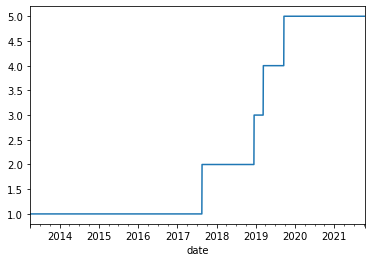

In [6]:
prices_ccxt.vwap.loc[:, 'BTC', :].groupby(['date']).count().plot()

In [7]:
prices_ccxt.index.get_level_values('exchange').unique().to_list()


['bitfinex', 'binance']

In [8]:
prices_ccxt.reset_index().to_feather(f'prices_ccxt_all')
prices_ccxt=prices_ccxt.droplevel(['exchange', 'symbol', 'quote', 'timeframe'])

In [9]:
universe = (prices_ccxt.where(prices_ccxt.groupby(['date', 'base'])
                             .dollar_vol_90d_rolling
                             .rank(ascending=False) <= 1.5)
            .dropna())
universe.sort_index(inplace=True)
universe

open       high        low       close        vwap  \
date       base                                                             
2013-04-01 BTC    92.500000   93.74999   91.00000   93.033000   92.570748   
2013-04-02 BTC    93.250000  105.90000   92.49999  103.999000   98.912248   
2013-04-03 BTC   104.000000  118.38670   99.00000  118.229354  109.904014   
2013-04-04 BTC   117.958261  146.88000  101.51088  134.700000  125.262285   
2013-04-05 BTC   134.716560  143.00000  119.00000  132.899000  132.403890   
...                     ...        ...        ...         ...         ...   
2021-10-14 ZCN     0.397430    0.40162    0.36770    0.396880    0.781815   
           ZEC   116.200000  119.70000  113.10000  119.400000  117.100000   
           ZEN    72.570000   73.48000   69.74000   73.220000   72.252500   
           ZIL     0.091500    0.09535    0.08949    0.094210    0.092637   
           ZRX     0.999800    1.02950    0.97260    1.028400    1.007575   

                       volume    dollar_vol  dollar_vol_90d_rolling  
date       base                                                      
2013-04-01 BTC   3.083080e+03  2.868282e+05            2.868282e+05  
2013-04-02 BTC   5.224401e+03  5.433325e+05            8.301607e+05  
2013-04-03 BTC   8.376527e+03  9.903514e+05            1.820512e+06  
2013-04-04 BTC   1.299625e+04  1.750594e+06            3.571106e+06  
2013-04-05 BTC   6.981668e+03  9.278567e+05            4.498963e+06  
...                       ...           ...                     ...  
2021-10-14 ZCN   8.171576e+03  3.243135e+03            2.592725e+06  
           ZEC   2.216192e+05  2.646133e+07            2.548582e+09  
           ZEN   8.261325e+04  6.048942e+06            1.302916e+09  
           ZIL   1.415960e+08  1.333976e+07            2.111828e+09  
           ZRX   3.818060e+06  3.926493e+06            6.994253e+08  

[234950 rows x 8 columns]

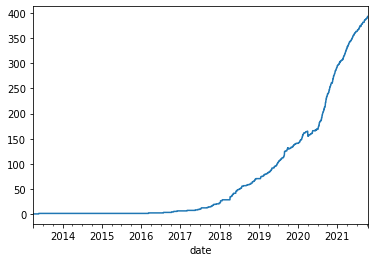

In [10]:
universe.vwap.groupby(['date']).count().plot()

universe = universe[~universe.index.duplicated(keep='first')]


<AxesSubplot:xlabel='date'>

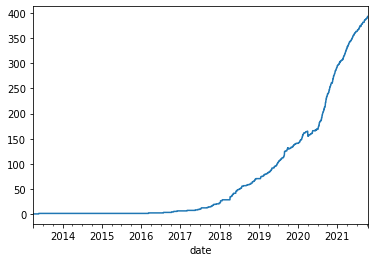

In [11]:
universe.vwap.groupby(['date']).count().plot()

In [12]:
universe.reset_index().to_feather(f'prices_ccxt_universe')


In [13]:
universe['coin_dv_rank_90d'] = universe.dollar_vol_90d_rolling.groupby('date').rank(ascending=False)
universe.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
open,234950.0,6.197099e+02,9.155855e+03,1.910000e-06,4.489000e-02,5.950000e-01,5.081000e+00,6.905400e+05
high,234950.0,6.531558e+02,9.839905e+03,2.260000e-06,4.780000e-02,6.369000e-01,5.436625e+00,7.378200e+05
low,234950.0,5.837075e+02,8.350454e+03,1.850000e-06,4.210000e-02,5.550550e-01,4.725000e+00,6.123500e+05
close,234950.0,6.202426e+02,9.146544e+03,1.880000e-06,4.479550e-02,5.944000e-01,5.076975e+00,6.754100e+05
vwap,234950.0,6.526411e+02,9.487594e+03,0.000000e+00,3.924056e-02,5.355000e-01,4.810000e+00,6.680425e+05
volume,234950.0,1.901426e+10,1.142381e+12,-9.142514e+10,6.893164e+04,1.362672e+06,1.806120e+07,2.461043e+14
dollar_vol,234950.0,3.143327e+07,2.128411e+08,-8.880456e+07,6.244754e+04,1.386512e+06,9.301488e+06,2.101685e+10
dollar_vol_90d_rolling,234950.0,2.500130e+09,1.491696e+10,-1.025702e+08,7.883974e+06,1.475666e+08,9.064264e+08,3.774758e+11
coin_dv_rank_90d,234950.0,1.172519e+02,9.543309e+01,1.000000e+00,3.800000e+01,9.300000e+01,1.780000e+02,3.930000e+02


In [14]:
universe.head()

,,open,high,low,close,vwap,volume,dollar_vol,dollar_vol_90d_rolling,coin_dv_rank_90d
date,base,,,,,,,,,
2013-04-01,BTC,92.500000,93.74999,91.00000,93.033000,92.570748,3083.079791,2.868282e+05,2.868282e+05,1.0
2013-04-02,BTC,93.250000,105.90000,92.49999,103.999000,98.912248,5224.401313,5.433325e+05,8.301607e+05,1.0
2013-04-03,BTC,104.000000,118.38670,99.00000,118.229354,109.904014,8376.527478,9.903514e+05,1.820512e+06,1.0
2013-04-04,BTC,117.958261,146.88000,101.51088,134.700000,125.262285,12996.245072,1.750594e+06,3.571106e+06,1.0
2013-04-05,BTC,134.716560,143.00000,119.00000,132.899000,132.403890,6981.668305,9.278567e+05,4.498963e+06,1.0


construct the most traded coins until 2021 to have less lookforward bias

In [75]:
absolute_dollar_volume = prices_ccxt.loc[:"2021-4", :].dollar_vol.groupby('base').sum().rank(ascending=False)
absolute_dollar_volume.sort_values().head(20)
top10 = absolute_dollar_volume.where(absolute_dollar_volume < 26).dropna()

In [76]:
top10.sort_values()

base
BTC      1.0
ETH      2.0
XRP      3.0
BNB      4.0
EOS      5.0
LTC      6.0
ADA      7.0
BUSD     8.0
LINK     9.0
DOT     10.0
DOGE    11.0
BCH     12.0
USDT    13.0
TRX     14.0
NEO     15.0
XLM     16.0
USDC    17.0
IOTA    18.0
ETC     19.0
CHZ     20.0
UNI     21.0
VET     22.0
SXP     23.0
YFI     24.0
GRT     25.0
Name: dollar_vol, dtype: float64

In [77]:
universe_top10dv = universe.join(top10, rsuffix='_rank', how='inner')

<AxesSubplot:xlabel='date'>

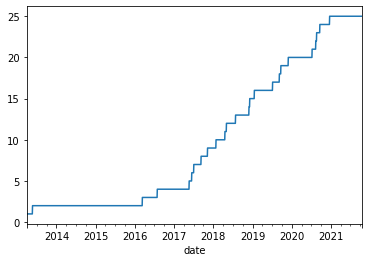

In [78]:
universe_top10dv.vwap.groupby(['date']).count().plot()

In [79]:
universe_top10dv.index.get_level_values('base').unique()

Index(['BTC', 'LTC', 'ETH', 'ETC', 'XRP', 'IOTA', 'EOS', 'NEO', 'BNB', 'TRX',
       'ADA', 'XLM', 'VET', 'USDT', 'USDC', 'LINK', 'DOGE', 'CHZ', 'BUSD',
       'BCH', 'SXP', 'YFI', 'DOT', 'UNI', 'GRT'],
      dtype='object', name='base')

In [80]:
universe_top10dv.groupby('base').close.count().sort_values()


base
GRT      301
UNI      392
DOT      422
YFI      430
SXP      464
BCH      686
BUSD     755
CHZ      769
DOGE     832
LINK    1002
USDC    1045
USDT    1052
VET     1177
XLM     1262
ADA     1276
TRX     1359
BNB     1438
NEO     1498
EOS     1566
IOTA    1585
XRP     1609
ETC     1906
ETH     2045
LTC     3068
BTC     3119
Name: close, dtype: int64

In [81]:
universe_top10dv.reset_index().to_feather(f'prices_ccxt_universe_top15dv')

